In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from classification import *
from xgboost_classifier import *
from testaccuracy import *

C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [3]:
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='textModel_win=2_no_outside'

In [4]:
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [5]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [6]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/textModel_win=2_no_outside


In [7]:
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [8]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([ 1.39154303,  2.02667713, -0.2595    ,  0.40349838, -2.51128626,
       -0.57653749, -0.2880269 ,  0.79625225, -1.72736251, -0.55669445,
       -0.1103246 , -0.25622737,  0.51354522,  1.64991832,  0.15828428,
       -1.31404865, -0.38595071,  0.11359195, -1.80308282, -0.3853884 ,
        0.12366654,  0.73094928, -0.59017813, -0.57282758, -0.56738102,
       -0.58856642, -0.1689133 , -1.38690603, -1.10290945,  2.44333291,
        0.85595089, -0.83670229, -0.46628171,  0.80855757,  1.76998258,
       -1.79520845,  0.25988749, -0.36671975,  0.7018944 , -1.01795661,
        0.97518283, -0.88528377, -0.26272607, -0.72158974,  0.17883518,
       -0.84870034, -1.12246311, -1.30428255,  0.55243754, -1.49376571,
       -0.97371197, -0.530312  ,  0.11352377, -0.07217326, -1.17716205,
       -0.98013484, -0.5437516 ,  1.75924706,  1.57688129,  1.23722923,
       -0.81333536, -0.88027573,  0.03753718, -0.96783006, -2.49287248,
        0.39773917, -1.93843079,  0.16352667, -1.13692153, -1.02

In [9]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [10]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   4.18523246e-19,   1.82140582e-19,
         5.52932734e-29,   9.01317672e-25,   1.47967745e-22,
        -8.38240178e-21,   2.00300590e-21,   9.74158370e-21,
        -9.34683441e-21,   1.91083889e-20,   6.55003880e-19,
        -1.09276438e-17,  -1.56730196e-18,  -2.12913704e-18,
        -4.51096312e-18,  -3.82900024e-19,   1.15894157e-17,
         1.59938703e-17,   3.58735292e-17,  -3.35304994e-18,
         1.68462844e-17,   6.76851697e-18,   5.86047343e-17,
         7.80129580e-21])

In [11]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

[0]	train-mlogloss:2.11882	valid-mlogloss:2.14064
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.06157	valid-mlogloss:1.43744
[50]	train-mlogloss:0.622666	valid-mlogloss:1.18083
[75]	train-mlogloss:0.396343	valid-mlogloss:1.05394
[100]	train-mlogloss:0.269717	valid-mlogloss:0.986567
[125]	train-mlogloss:0.190567	valid-mlogloss:0.960457
[150]	train-mlogloss:0.13717	valid-mlogloss:0.947585
[175]	train-mlogloss:0.1003	valid-mlogloss:0.945835
[200]	train-mlogloss:0.075294	valid-mlogloss:0.949354
[225]	train-mlogloss:0.057313	valid-mlogloss:0.952471
[250]	train-mlogloss:0.045023	valid-mlogloss:0.959883
Stopping. Best iteration:
[163]	train-mlogloss:0.11638	valid-mlogloss:0.944728

final validation loss:
0.94472836195
final validation accuracy:
0.691056910569
[0]	train-mlogloss:2.11774	valid-mlogloss:2.13464
Multiple eval metrics have been passed: 'valid-mlogloss' 

[200]	train-mlogloss:0.073068	valid-mlogloss:0.905568
[225]	train-mlogloss:0.056288	valid-mlogloss:0.910894
[250]	train-mlogloss:0.044275	valid-mlogloss:0.91156
[275]	train-mlogloss:0.035806	valid-mlogloss:0.918342
Stopping. Best iteration:
[187]	train-mlogloss:0.08484	valid-mlogloss:0.904588

final validation loss:
0.904587964545
final validation accuracy:
0.674796747967
[0]	train-mlogloss:2.11687	valid-mlogloss:2.14224
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.06591	valid-mlogloss:1.4807
[50]	train-mlogloss:0.634764	valid-mlogloss:1.2424
[75]	train-mlogloss:0.401686	valid-mlogloss:1.12395
[100]	train-mlogloss:0.271526	valid-mlogloss:1.06392
[125]	train-mlogloss:0.189027	valid-mlogloss:1.02844
[150]	train-mlogloss:0.133223	valid-mlogloss:1.01306
[175]	train-mlogloss:0.096258	valid-mlogloss:1.01222
[200]	train-mlogloss:0.071475	valid-mlogloss:1.01273
[22

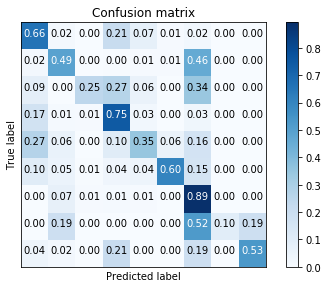

In [12]:
y_predict = xgbclassifier(train_set, train_y, test_set, 10, 8, 1000)

In [14]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin2noload30fold.csv")